In [4]:
# 0.1 Install community detection library (required for Louvain)
!pip install python-louvain networkx matplotlib pandas

# 0.2 Import core libraries
import pandas as pd
import re
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Set the visualization style
plt.style.use('ggplot')

In [6]:
# --- 1.1 Load and Filter Data (FIXED CODE) ---
from google.colab import drive
import pandas as pd

# Mount your Google Drive
drive.mount('/content/drive')

# Example: Read a CSV file from your Drive
# Replace 'path/to/your/file.csv' with the actual path to your file

file_path = '/content/drive/My Drive/IPL_2022_tweets.csv' # Update this path
df = pd.read_csv(file_path, low_memory=False)
# 1. Convert 'date' column to datetime objects using the 'coerce' error handling.
# This forces invalid/unparsable entries (like the hashtag list you saw) to become NaT (Not a Time).
# NOTE: If your actual date column is named something else (e.g., 'dates'), change df['date'] to df['dates'].
try:
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
except KeyError:
    print("KeyError: Column 'date' not found. Please check the actual column name for the timestamp (e.g., 'dates' or 'created_at').")
    # If a KeyError occurs, stop here and ask the user to check the correct column name.
    raise

# 2. Drop rows where date conversion failed (i.e., where the entry was not a date at all)
df.dropna(subset=['date'], inplace=True)
print(f"Total rows after cleaning invalid dates: {len(df)}")

# 3. Filter for the 2022 IPL season (March 26, 2022 to May 29, 2022)
start_date = pd.to_datetime('2022-03-26', utc=True)
end_date = pd.to_datetime('2022-05-30', utc=True) # Use day after end date for inclusive filtering

df_2022 = df[(df['date'] >= start_date) & (df['date'] < end_date)].copy()

print(f"\nTotal tweets in 2022 season (filtered): {len(df_2022)}")

Mounted at /content/drive
Total rows after cleaning invalid dates: 574646

Total tweets in 2022 season (filtered): 490225


In [7]:
# --- 1.2 Define Fan Affiliation (Node Attribute) ---
print("Starting Fan Affiliation Calculation...")

# Key official and fan hashtags for the 10 IPL teams
TEAMS = {
    'CSK': ['#CSK', '#WhistlePodu', 'chennaisuperkings'],
    'MI': ['#MI', '#MumbaiIndians', 'rohitsharma', 'mumbaiindians'],
    'RCB': ['#RCB', '#PlayBold', 'royalchallengersbangalore', 'viratkohli'],
    'RR': ['#RR', '#HallaBol', 'rajasthanroyals', 'josbuttler'],
    'DC': ['#DC', '#YehHaiNayiDilli', 'delhicapitals', 'rishabhpant'],
    'PBKS': ['#PBKS', '#PunjabKings', 'mayankagarwal'],
    'SRH': ['#SRH', '#OrangeArmy', 'sunrisershyderabad'],
    'GT': ['#GT', '#AmiGujaratTitans', 'gujarattitans', 'hardik'],
    'LSG': ['#LSG', '#LucknowSuperGiants', 'klrahul'],
    'KKR': ['#KKR', '#AmiKKR', 'kolkataknightriders']
}

# Normalize text for easier matching
df_2022['text_lower'] = df_2022['text'].astype(str).str.lower()

# Function to assign primary team affiliation to each user based on hashtag count
def get_primary_team(user_data):
    scores = defaultdict(int)
    text_corpus = ' '.join(user_data['text_lower'].tolist())

    for team, tags in TEAMS.items():
        # Score based on presence of key tags/words in their collected tweets
        score = sum(text_corpus.count(tag.lower()) for tag in tags)
        scores[team] = score

    # Determine the team with the highest total score
    if any(scores.values()):
        return max(scores, key=scores.get)
    return 'Neutral'

# Group by user to analyze their total posting behavior in 2022
user_groups = df_2022.groupby('user_name')
user_affiliations = {name: get_primary_team(data) for name, data in user_groups}

print(f"Calculated affiliations for {len(user_affiliations)} unique users.")

# --- 1.3 Create Edge List (Interactions) ---
# Regex to find any potential Twitter mention (user interaction)
MENTION_PATTERN = r'@([A-Za-z0-9_]+)'

edge_counts = defaultdict(int)
for index, row in df_2022.iterrows():
    # Ensure source is a string before processing
    source = str(row['user_name'])

    # Find all mentions in the text
    targets = re.findall(MENTION_PATTERN, row['text'])

    # Check for retweets (RTs) explicitly to increase weight
    is_retweet = str(row['text']).startswith('RT @')

    for target in targets:
        # Ensure target is a string before processing and prevent self-loops and empty mentions
        if source.lower() != str(target).lower() and str(target):
            # Edges are (Source, Target)
            edge = (source, str(target))

            # Weight is higher for a Retweet (stronger endorsement/diffusion)
            weight_increment = 2 if is_retweet else 1
            edge_counts[edge] += weight_increment

# Convert dictionary to DataFrame for NetworkX
final_edges_df = pd.DataFrame([
    {'source': s, 'target': t, 'weight': w}
    for (s, t), w in edge_counts.items()
])

print(f"Total unique interactions (edges) for 2022: {len(final_edges_df)}")

Starting Fan Affiliation Calculation...
Calculated affiliations for 49103 unique users.
Total unique interactions (edges) for 2022: 118833


In [12]:
# Convert to undirected for modularity analysis
import community.community_louvain as community_louvain

G_undirected = G_full.to_undirected(as_view=True)

# Run the Louvain algorithm
partition = community_louvain.best_partition(
    G_undirected,
    weight='weight',
    random_state=42
)

# Calculate modularity
modularity_score = community_louvain.modularity(
    partition,
    G_undirected,
    weight='weight'
)

print("-" * 60)
print(f"**Structural Polarization (Modularity Score, Q): {modularity_score:.4f}**")
print("-" * 60)


------------------------------------------------------------
**Structural Polarization (Modularity Score, Q): 0.4894**
------------------------------------------------------------


In [9]:
pip install python-louvain



Visualizing a random sample of 2000 nodes...


/tmp/ipython-input-29563923.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral', max(partition.values()) + 1)
/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


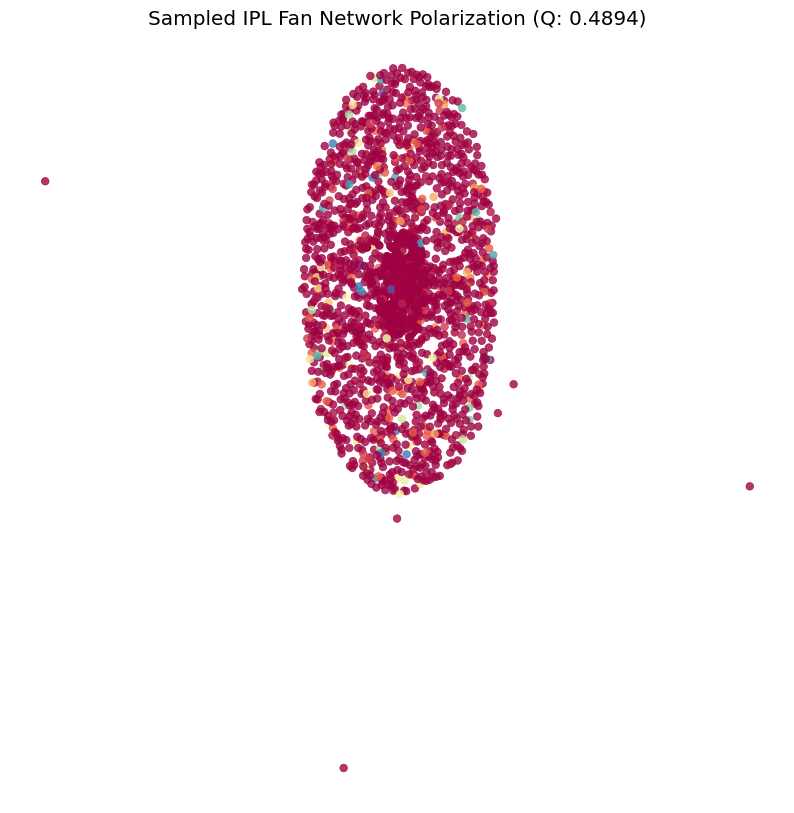

In [13]:
# --- 2.3 Alternative: Random Sampling Visualization (Very Fast) ---

# 1. Select a small, manageable sample of nodes (e.g., 2000 users)
sample_size = min(2000, G_undirected.number_of_nodes())
sampled_nodes = np.random.choice(G_undirected.nodes(), size=sample_size, replace=False)

# 2. Create the subgraph based on the sample
G_sample = G_undirected.subgraph(sampled_nodes)

print(f"\nVisualizing a random sample of {G_sample.number_of_nodes()} nodes...")
pos_sample = nx.spring_layout(G_sample, k=0.3, iterations=20, seed=42)
cmap = plt.cm.get_cmap('Spectral', max(partition.values()) + 1)
sample_node_colors = [cmap(partition[node]) for node in G_sample.nodes()]

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(
    G_sample, pos_sample,
    node_size=30,
    cmap=cmap,
    node_color=sample_node_colors,
    alpha=0.8
)
nx.draw_networkx_edges(
    G_sample, pos_sample,
    alpha=0.1,
    edge_color='gray',
    width=0.3
)
plt.title(f"Sampled IPL Fan Network Polarization (Q: {modularity_score:.4f})")
plt.axis('off')
plt.show()

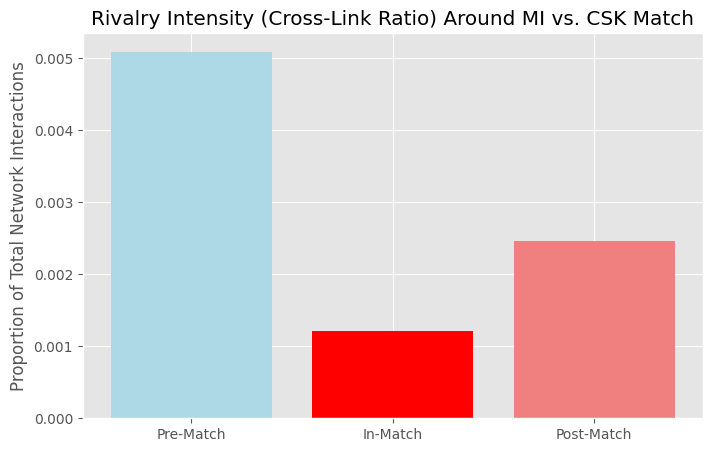


Calculating Betweenness Centrality for In-Match Graph...
------------------------------------------------------------
Top 10 Non-Rival Gatekeepers (High BC) In-Match:
  ymediagroup (Team: RR) - BC Score: 0.000000
  🏏CricDomestic🏏 (Team: RCB) - BC Score: 0.000000
  Aman singh (Team: DC) - BC Score: 0.000000
  Khaja Moinuddin (Team: LSG) - BC Score: 0.000000
  Syed Wasi Abbas (Team: RR) - BC Score: 0.000000
  Mohammed Rumman Khan (Team: GT) - BC Score: 0.000000
  M Àbdullah🇵🇰 (Team: RR) - BC Score: 0.000000
  taha abbas 🦁 (Team: GT) - BC Score: 0.000000
  IPL (Team: LSG) - BC Score: 0.000000
  Satyam kumar (Team: RCB) - BC Score: 0.000000
------------------------------------------------------------


In [15]:
# --- 3.1 Define Rivalry Time Slices ---

rivalry_teams = ['MI', 'CSK']
# MI vs CSK match on April 21, 2022. Match start: 19:30 IST
match_start_time = pd.to_datetime('2022-04-21 14:00:00', utc=True)

time_slices = {
    'Pre-Match': (match_start_time - pd.Timedelta(days=3), match_start_time),
    'In-Match': (match_start_time, match_start_time + pd.Timedelta(hours=8)),
    'Post-Match': (match_start_time + pd.Timedelta(hours=8), match_start_time + pd.Timedelta(days=3) + pd.Timedelta(hours=8))
}

rivalry_ratios = {}
G_in_match = None # Initialize the In-Match graph container

# --- 3.2 Loop and Analyze Temporal Graphs ---

for slice_name, (start, end) in time_slices.items():
    # Filter tweets for the specific time slice
    df_slice = df_2022[(df_2022['date'] >= start) & (df_2022['date'] < end)].copy() # Add .copy() to avoid SettingWithCopyWarning

    # Re-extract edges for this slice
    slice_edge_counts = defaultdict(int)
    for index, row in df_slice.iterrows():
        # Ensure source is a string before processing
        source = str(row['user_name'])
        targets = re.findall(r'@([A-Za-z0-9_]+)', row['text'])
        is_retweet = str(row['text']).startswith('RT @') # Ensure text is string

        for target in targets:
            # Ensure target is a string before processing and prevent self-loops and empty mentions
            if source.lower() != str(target).lower() and str(target):
                slice_edge_counts[(source, str(target))] += (2 if is_retweet else 1) # Ensure target in edge is string


    if not slice_edge_counts:
        rivalry_ratios[slice_name] = 0
        print(f"Warning: No interactions found for {slice_name}.")
        continue

    # Build the temporal graph
    slice_edges_df = pd.DataFrame([{'source': s, 'target': t, 'weight': w} for (s, t), w in slice_edge_counts.items()])

    # Check if there are nodes in the graph before attempting to set attributes
    nodes_in_slice = set(slice_edges_df['source']).union(set(slice_edges_df['target']))
    if not nodes_in_slice:
         rivalry_ratios[slice_name] = 0
         print(f"Warning: No nodes found for {slice_name}.")
         continue

    G_slice = nx.from_pandas_edgelist(
        slice_edges_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph()
    )

    # Filter user_affiliations to only include nodes present in the current slice graph
    user_affiliations_slice = {user: team for user, team in user_affiliations.items() if user in G_slice.nodes()}

    # Set node attributes only for nodes that exist in the graph
    nx.set_node_attributes(G_slice, user_affiliations_slice, 'Primary_Team')


    if slice_name == 'In-Match':
        G_in_match = G_slice.copy() # Save for Betweenness Centrality

    # Calculate Cross-Rivalry Links (The rivalry intensity metric)
    cross_links_weight = 0
    # Sum of all edge weights in the slice
    total_network_weight = sum(data.get('weight', 1) for u, v, data in G_slice.edges(data=True))


    for u, v, data in G_slice.edges(data=True):
        # Ensure nodes u and v exist in the graph and have the 'Primary_Team' attribute
        u_team = G_slice.nodes[u].get('Primary_Team') if u in G_slice.nodes() else None
        v_team = G_slice.nodes[v].get('Primary_Team') if v in G_slice.nodes() else None


        # Check for interaction between an MI fan and a CSK fan
        if (u_team in rivalry_teams and v_team in rivalry_teams) and (u_team != v_team):
            cross_links_weight += data.get('weight', 1)

    # Handle potential division by zero if there are no interactions
    rivalry_ratios[slice_name] = cross_links_weight / total_network_weight if total_network_weight > 0 else 0


# --- 3.3 Visualize Rivalry Intensity (Temporal) ---
names = list(rivalry_ratios.keys())
ratios = list(rivalry_ratios.values())

plt.figure(figsize=(8, 5))
plt.bar(names, ratios, color=['lightblue', 'red', 'lightcoral'])
plt.title('Rivalry Intensity (Cross-Link Ratio) Around MI vs. CSK Match')
plt.ylabel('Proportion of Total Network Interactions')
plt.show()


# --- 3.4 Identify Gatekeepers (Bridge Users) ---
if G_in_match and G_in_match.number_of_nodes() > 0: # Check if In-Match graph exists and has nodes
    print("\nCalculating Betweenness Centrality for In-Match Graph...")

    # Calculate Betweenness Centrality (BC) - measures how often a node lies on the shortest path
    # Use min(G_in_match.number_of_nodes(), 200) to avoid errors on small graphs
    betweenness = nx.betweenness_centrality(G_in_match, weight='weight', k=min(G_in_match.number_of_nodes(), 200))


    # Identify users who are NOT MI or CSK fans but have high centrality (true "bridges")
    non_rival_gatekeepers = {}
    for user, score in betweenness.items():
        team = G_in_match.nodes[user].get('Primary_Team', 'N/A') # Use .get() with default for safety
        if team not in rivalry_teams and team != 'Neutral' and team != 'N/A':
            non_rival_gatekeepers[user] = score

    # Find the top 10 from the non-rivals/neutral set
    top_gatekeepers = sorted(non_rival_gatekeepers.items(), key=lambda item: item[1], reverse=True)[:10]

    print("-" * 60)
    print("Top 10 Non-Rival Gatekeepers (High BC) In-Match:")
    if top_gatekeepers:
        for user, score in top_gatekeepers:
            team = G_in_match.nodes[user].get('Primary_Team', 'N/A')
            print(f"  {user} (Team: {team}) - BC Score: {score:.6f}")
    else:
        print("  No non-rival gatekeepers found.")
    print("-" * 60)
else:
    print("In-Match graph was empty or could not be built. Check time slice filtering or data availability.")